# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
num_workers = 0
batch_size = 20
valid_size = 0.2

train_path = r'C:\Users\pedro\PythonFile\landmarks-tagging\landmark_project\landmark_images\train'
test_path = r'C:\Users\pedro\PythonFile\landmarks-tagging\landmark_project\landmark_images\test'

train_transform = transforms.Compose([transforms.Resize((240,240)), transforms.CenterCrop(240), 
                                        transforms.RandomRotation(10), 
                                        transforms.RandomAutocontrast(p=0.2), 
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
test_transform = transforms.Compose([transforms.Resize((240,240)), transforms.CenterCrop(240), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

train_data = torchvision.datasets.ImageFolder(train_path, train_transform)
test_data = torchvision.datasets.ImageFolder(test_path, test_transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
I have applied a resize of all the images to 240x240 pixels in order to be sure that all the loaded images have the same scale and then the convolutional neural network can handle all the batches pretty consistently and without errors, at the same time I have cropped the resized image from the center to assure that the algorithms will focus on the characteristics that were relevant to person that took the photograph.

I have decided to try some data augmentation techniques, so the neural net can generalize better over the image dataset. I have used mainly two techniques a random rotation of 10 degrees and a random change in contrast (that is applied with a probability of 20%). The first one is intended to get more data with slightly changes in orientation and the second one is for changes in the ilumination of the photo scene.

An important fact about the preprocessing of the images converted to tensors is that, as a final preprocessing step, is necessary to normalize the tensors, so the neural net would improve in its patterns identification and finally achieving a good accuracy.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

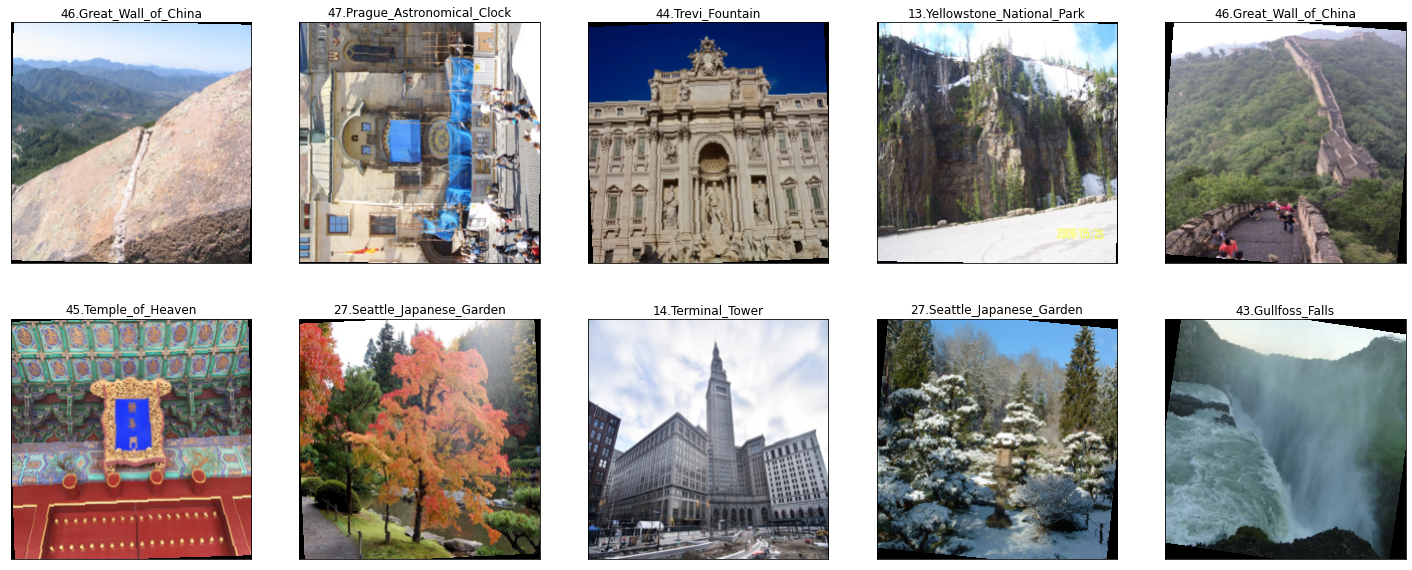

In [2]:
## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1,2,0))) # Convert tensor again to image

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25,10))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(train_data.classes[labels[idx]])




### Initialize use_cuda variable

In [3]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

if use_cuda:
    print('Training using GPU...')

Training using GPU...


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [4]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    return optimizer

    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [5]:

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        
        self.maxpool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(15 * 15 * 128, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 50)

        self.dropout = nn.Dropout(p=0.3)      
        
    
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        x = x.view(-1, 15 * 15 * 128)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)      
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__

As described in the course materials and in the different bibliography that is available on Internet, for getting a good classification neural net is important to obtain the features map of the images progressively, for that is necessary to stack convolutional layers that will increase the depth of the feature maps with pooling layers that will provide the mechanisms to discard not important features and focus in the relevant ones. The limit for the number of the stacked layers is the final sizing of the feature map, we can not get to negative scales, and also that a high number of layers will tend to overfit the model during training.

So, in our case I have used 4 convolutional layers with a kernel size of 3 and padding 1, so at the output of the layer is the same size but with different depth depending on the size of the used filter (I have used from 16 to 128), the pooling layer is a Maxpooling one with a kernel size of 2 and a stride of 2, that will get the maximum value of the different pixels that are under the pooling kernel in a certain step of the pooling.

The output of the convolutional/pooling stack is fed to a fully connected layers, but for doing that we need to flatten the tensor, once we have done that we fed it to the dense layers, beginning with 1024 nodes and finishing in 50 (number of classes we need to classify). In between these dense layers I havee applied dropout (30% of probability) to avoid overfitting.

The activation function used for all the layers, but the last one, have been a ReLU activation function.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [6]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss_tr = criterion(output, target)
            loss_tr.backward()
            optimizer.step()

            train_loss = train_loss + ((1 /(batch_idx + 1)) * (loss_tr.item() - train_loss))

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            loss_test = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx +1)) * (loss_test.item() - valid_loss))
            
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        
        if valid_loss < valid_loss_min:
            print('Validation loss has descreased ({:.6f}-->{:.6f}). Saving model...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [7]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    class_name = m.__class__.__name__

    if class_name.find('Linear') != -1:
        n = m.in_features
        y = (1 / np.sqrt(n))
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)
    
   

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(10, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.912217 	Validation Loss: 3.912195
Validation loss has descreased (inf-->3.912195). Saving model...
Epoch: 2 	Training Loss: 3.911810 	Validation Loss: 3.912304
Epoch: 3 	Training Loss: 3.911303 	Validation Loss: 3.912362
Epoch: 4 	Training Loss: 3.910820 	Validation Loss: 3.912473
Epoch: 5 	Training Loss: 3.910199 	Validation Loss: 3.912037
Validation loss has descreased (3.912195-->3.912037). Saving model...
Epoch: 6 	Training Loss: 3.909208 	Validation Loss: 3.911196
Validation loss has descreased (3.912037-->3.911196). Saving model...
Epoch: 7 	Training Loss: 3.907602 	Validation Loss: 3.908939
Validation loss has descreased (3.911196-->3.908939). Saving model...
Epoch: 8 	Training Loss: 3.904481 	Validation Loss: 3.904259
Validation loss has descreased (3.908939-->3.904259). Saving model...
Epoch: 9 	Training Loss: 3.893952 	Validation Loss: 3.885530
Validation loss has descreased (3.904259-->3.885530). Saving model...
Epoch: 10 	Training Loss: 3.846390 	

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [8]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 25

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.912489 	Validation Loss: 3.912542
Validation loss has descreased (inf-->3.912542). Saving model...
Epoch: 2 	Training Loss: 3.912025 	Validation Loss: 3.912665
Epoch: 3 	Training Loss: 3.911376 	Validation Loss: 3.912752
Epoch: 4 	Training Loss: 3.910902 	Validation Loss: 3.912665
Epoch: 5 	Training Loss: 3.910227 	Validation Loss: 3.912205
Validation loss has descreased (3.912542-->3.912205). Saving model...
Epoch: 6 	Training Loss: 3.909039 	Validation Loss: 3.911237
Validation loss has descreased (3.912205-->3.911237). Saving model...
Epoch: 7 	Training Loss: 3.906407 	Validation Loss: 3.908921
Validation loss has descreased (3.911237-->3.908921). Saving model...
Epoch: 8 	Training Loss: 3.901924 	Validation Loss: 3.901980
Validation loss has descreased (3.908921-->3.901980). Saving model...
Epoch: 9 	Training Loss: 3.885779 	Validation Loss: 3.871471
Validation loss has descreased (3.901980-->3.871471). Saving model...
Epoch: 10 	Training Loss: 3.812333 	

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [9]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.157676


Test Accuracy: 21% (269/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [10]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

batch_transfer_size = 20
valid_transfer_size = 0.2

train_transfer_transform = transforms.Compose([transforms.Resize((240,240)), transforms.CenterCrop(240), 
                                        transforms.RandomRotation(10), 
                                        transforms.RandomAutocontrast(p=0.2), 
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
test_transfer_transform = transforms.Compose([transforms.Resize((240,240)), transforms.CenterCrop(240), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])

train_transfer_data = torchvision.datasets.ImageFolder(train_path, train_transfer_transform)
test_transfer_data = torchvision.datasets.ImageFolder(test_path, test_transfer_transform)

num_train = len(train_transfer_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_transfer_sampler = SubsetRandomSampler(train_idx)
valid_transfer_sampler = SubsetRandomSampler(valid_idx)

train_transfer_loader = torch.utils.data.DataLoader(train_transfer_data, batch_size=batch_transfer_size, sampler=train_transfer_sampler, num_workers=num_workers)
valid_transfer_loader = torch.utils.data.DataLoader(train_transfer_data, batch_size=batch_transfer_size, sampler=valid_transfer_sampler, num_workers=num_workers)
test_transfer_loader = torch.utils.data.DataLoader(test_transfer_data, batch_size=batch_transfer_size, num_workers=num_workers)


loaders_transfer = {'train': train_transfer_loader, 'valid': valid_transfer_loader, 'test': test_transfer_loader}





### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [11]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    return optimizer
    
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [12]:
## TODO: Specify model architecture

model_transfer = torchvision.models.vgg16(pretrained=True)

# Freeze parameters of convolution layers from imported model.
for param in model_transfer.features.parameters():
    param.requires_grad = False

# Change fully connected layers to the ones that we need for our problem

n_inputs = model_transfer.classifier[6].in_features

new_layer = nn.Linear(n_inputs, 50)

model_transfer.classifier[6] = new_layer

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [13]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
n_epochs_transfer = 25

model_transfer = train(n_epochs_transfer, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), criterion_transfer, use_cuda, 'model_transfer.pt')


#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.248601 	Validation Loss: 1.445360
Validation loss has descreased (inf-->1.445360). Saving model...
Epoch: 2 	Training Loss: 1.294665 	Validation Loss: 1.209971
Validation loss has descreased (1.445360-->1.209971). Saving model...
Epoch: 3 	Training Loss: 0.996853 	Validation Loss: 1.169897
Validation loss has descreased (1.209971-->1.169897). Saving model...
Epoch: 4 	Training Loss: 0.796136 	Validation Loss: 1.120976
Validation loss has descreased (1.169897-->1.120976). Saving model...
Epoch: 5 	Training Loss: 0.635005 	Validation Loss: 1.064540
Validation loss has descreased (1.120976-->1.064540). Saving model...
Epoch: 6 	Training Loss: 0.530440 	Validation Loss: 1.068715
Epoch: 7 	Training Loss: 0.433720 	Validation Loss: 1.035756
Validation loss has descreased (1.064540-->1.035756). Saving model...
Epoch: 8 	Training Loss: 0.353934 	Validation Loss: 1.079045
Epoch: 9 	Training Loss: 0.312951 	Validation Loss: 1.082819
Epoch: 10 	Training Loss: 0.254671 	

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [14]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.903314


Test Accuracy: 75% (940/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [15]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    img = Image.open(img_path)
    convert_tensor = transforms.Compose([transforms.Resize((240,240)), transforms.CenterCrop(240), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
    tensor = convert_tensor(img)
    tensor.unsqueeze_(0)

    if use_cuda:
        tensor = tensor.cuda()
    
    model_transfer.eval()

    output = model_transfer(tensor)

    values, index = torch.topk(output, k, dim=1)

    model_transfer.train()
    
    selected_landmarks = []
    for i in index[0].tolist():
        selected_landmarks.append(train_data.classes[i])

    return selected_landmarks


# test on a sample image
predicted_landmark = predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)
print(predicted_landmark)

['09.Golden_Gate_Bridge', '38.Forth_Bridge', '30.Brooklyn_Bridge', '28.Sydney_Harbour_Bridge', '16.Eiffel_Tower']


### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

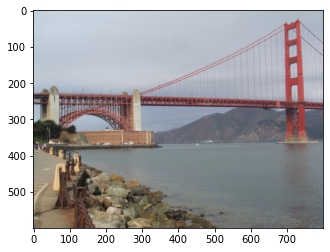

Is this picture of the  Golden_Gate_Bridge ,  Forth_Bridge , or  Brooklyn_Bridge ?


In [25]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    print('Is this picture of the ', predicted_landmarks[0].split('.')[1], ', ', predicted_landmarks[1].split('.')[1], ', or ', predicted_landmarks[2].split('.')[1], '?')
    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

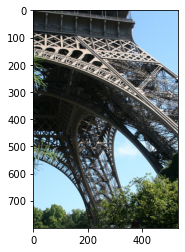

Is this picture of the  Eiffel_Tower ,  Sydney_Harbour_Bridge , or  Monumento_a_la_Revolucion ?


In [26]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

suggest_locations('images/test/16.Eiffel_Tower/3828627c8730f160.jpg')

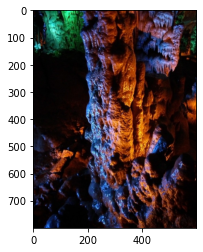

Is this picture of the  Soreq_Cave ,  Great_Barrier_Reef , or  London_Olympic_Stadium ?


In [27]:
suggest_locations('images/test/24.Soreq_Cave/18dbbad48a83a742.jpg')

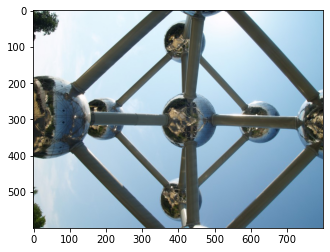

Is this picture of the  Atomium ,  Eiffel_Tower , or  Sydney_Harbour_Bridge ?


In [28]:
suggest_locations('images/test/37.Atomium/5ecb74282baee5aa.jpg')

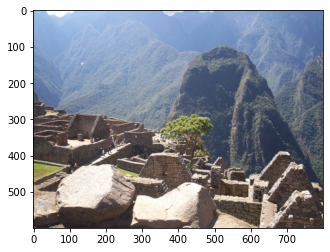

Is this picture of the  Machu_Picchu ,  Great_Wall_of_China , or  Banff_National_Park ?


In [29]:
suggest_locations('images/test/41.Machu_Picchu/4336abf3179202f2.jpg')